In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(timg,_),(_,_) = mnist.load_data()
timg = (timg.astype(np.float32) - 127.5) / 127.5

timg = np.expand_dims(timg, axis=3) 
img_shape=(28,28,1)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
def make_gino():

  model = Sequential()
  model.add(Dense(256, input_shape=(100,)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
    
  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))
  return model



In [4]:
optimizer = Adam(0.0002, 0.5)

In [5]:
gino = make_gino()

In [6]:
gino.compile(loss='binary_crossentropy', optimizer=optimizer)

In [7]:
def make_diso():
  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  return model
  

In [8]:
diso = make_diso()

In [9]:
diso.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

In [11]:
z = Input(shape=(100,))
img = gino(z)
diso.trainable = False  
valid = diso(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [12]:
def train(epochs=10, batch_size=128):

  half_batch = int(batch_size / 2)

  for epoch in range(epochs):

    idx = np.random.randint(0, timg.shape[0], half_batch)
    imgs = timg[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))

    gen_imgs=gino.predict(noise)

    diso.train_on_batch(imgs, np.ones((half_batch, 1)))
    diso.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    valid_y = np.array([1] * batch_size)
    g_loss = combined.train_on_batch(noise, valid_y)




In [26]:
train(epochs=10000, batch_size=256)

In [30]:
noise = np.random.normal(0, 1, (60, 100))
u=gino.predict(noise)

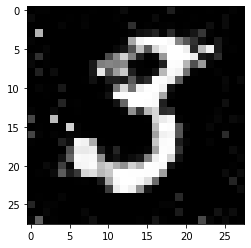

In [36]:
plt.imshow(np.reshape(u[59],(28,28)),cmap='gray')